In [49]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/scratch/ewalt/pdm/rs-uncertainty")
import sys
sys.path.insert(0, "gee")
from utils import getStatDataFrame
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set()
sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def loadRasters(*paths, bands=None, dtype=None):
    res = []
    for path in paths:
        with rasterio.open(path) as f:
            if bands is None: bands = list(range(1, f.count+1))
            data = f.read(bands)
            if dtype is not None: data = data.astype(dtype)
            res.append(data)
    return res

def clip(arr, bounds, normalize=True):
    bounds = (float(bounds[0]), float(bounds[1]))
    arr = np.where(arr>bounds[1], bounds[1], arr)
    arr = np.where(arr<bounds[0], bounds[0], arr)
    if normalize: arr /= bounds[1]
    return arr

def showRaster(rasterData, title, ax):
    if rasterData.shape[-1]==3:
        ax.imshow(rasterData)
    else:
        sns.heatmap(rasterData, cmap="Spectral_r", ax=ax)
    ax.set_axis_off()
    ax.set_title(title)

def showWarping(ref_path, rio_path, gee_path, bands, bounds=(0, 2000), suffix="", islice=None, jslice=None):
    assert len(bands) in [1, 3]
    dtype = "float" if len(bands)==3 else None
    # get data
    rasters = loadRasters(ref_path, rio_path, gee_path, bands=bands, dtype=dtype)
    # select bands
    for i, raster in enumerate(rasters):
        raster = raster.transpose(1,2,0)
        if islice is not None: raster = raster[islice,:,:]
        if jslice is not None: raster = raster[:,jslice,:]
        if len(bands)==1: raster = raster[:,:,0]
        raster = clip(raster, bounds)
        rasters[i] = raster
    # split tuple
    refData, rioData, geeData = rasters
    # plot
    figsize = (12,7) if len(bands)==3 else (12,3)
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    titles = [f"{kind} {suffix}" for kind in ["ref", "rio", "gee"]]
    for args in zip(rasters, titles, axs):
        showRaster(*args)
    plt.show()

In [45]:
ref_path = "/scratch/ewalt/pdm/rs-uncertainty/assets/data/sentinel_data/s2_reprojected/1023/1023_S2B_MSIL2A_20180705T105029_N0208_R051_T32VNM_20180705T144546.tif"
rio_path = "/scratch/ewalt/pdm/rs-uncertainty/gee_data/rio_warp_tests/1023_GEE_COPERNICUS-S2-SR-HARMONIZED_20180705T105029_20230523T194020.tif"
gee_path = "/scratch/ewalt/pdm/rs-uncertainty/gee_data/original/1023/1023_GEE_COPERNICUS-S2-SR-HARMONIZED_20180705T105029_20230523T194020.tif"

# Visualization

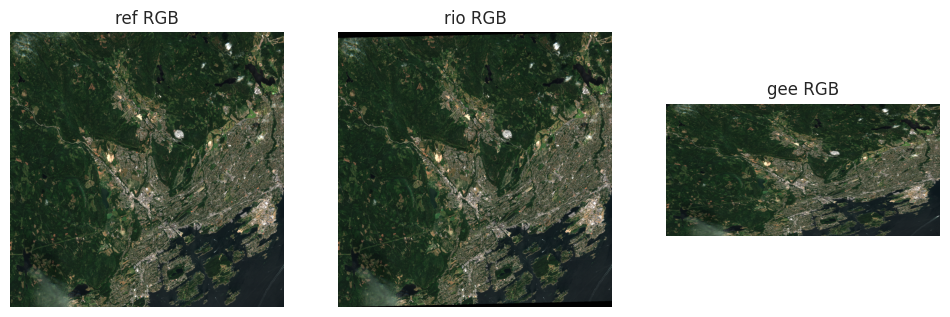

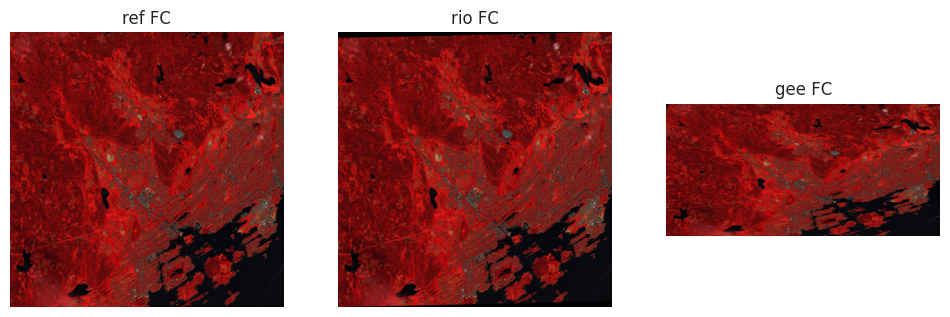

In [46]:
showWarping(ref_path, rio_path, gee_path, [4,3,2], bounds=(0, 2000), suffix="RGB", islice=None, jslice=None)
showWarping(ref_path, rio_path, gee_path, [8,4,2], bounds=(0, 5000), suffix="FC", islice=None, jslice=None)

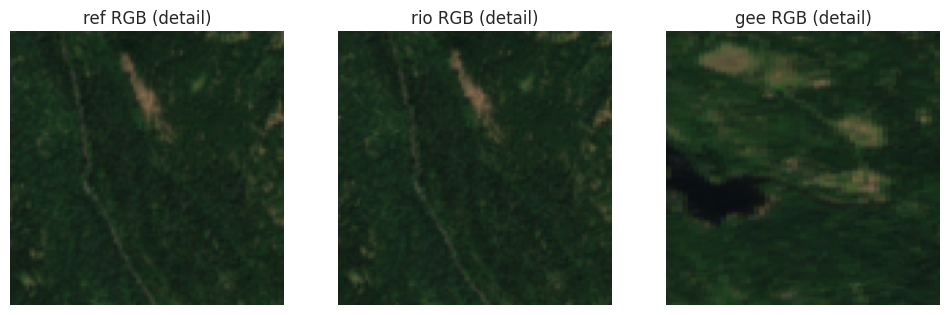

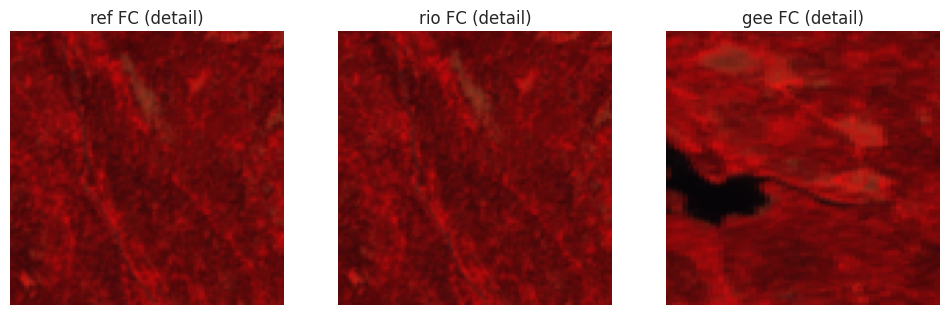

In [47]:
showWarping(ref_path, rio_path, gee_path, [4,3,2], bounds=(0, 2000), suffix="RGB (detail)", islice=slice(200,300), jslice=slice(200,300))
showWarping(ref_path, rio_path, gee_path, [8,4,2], bounds=(0, 5000), suffix="FC (detail)", islice=slice(200,300), jslice=slice(200,300))

# Statistics

No rescaling needed!

In [61]:
refData, rioData = loadRasters(ref_path, rio_path)

In [63]:
getStatDataFrame(refData, rioData, stat_name="min", nodata=0.)

,band,stat,ref,rio,rio_delta
0,0,min,0,0,0
1,1,min,1,1,0
2,2,min,1,1,0
3,3,min,1,1,0
4,4,min,35,35,0
5,5,min,0,0,0
6,6,min,3,3,0
7,7,min,49,49,0
8,8,min,6,6,0
9,9,min,0,0,0


In [64]:
getStatDataFrame(refData, rioData, stat_name="max", nodata=0.)

,band,stat,ref,rio,rio_delta
0,0,max,2456,2456,0
1,1,max,17840,17840,0
2,2,max,16960,16960,0
3,3,max,16272,16272,0
4,4,max,16017,16017,0
5,5,max,15759,15759,0
6,6,max,14968,14968,0
7,7,max,15744,15744,0
8,8,max,15495,15495,0
9,9,max,5633,5633,0


In [65]:
getStatDataFrame(refData, rioData, stat_name="mean", nodata=0.)

,band,stat,ref,rio,rio_delta
0,0,mean,174.316134,174.528809,-0.212675
1,1,mean,361.008689,361.636301,-0.627612
2,2,mean,493.278246,494.921102,-1.642856
3,3,mean,395.771839,397.381264,-1.609425
4,4,mean,748.256627,751.922176,-3.665549
5,5,mean,1760.646323,1770.762812,-10.116490
6,6,mean,2137.054849,2149.849841,-12.794992
7,7,mean,2201.055916,2214.347528,-13.291612
8,8,mean,2305.481567,2319.353876,-13.872308
9,9,mean,2275.371289,2289.222699,-13.851410


In [66]:
getStatDataFrame(refData, rioData, stat_name="std", nodata=0.)

,band,stat,ref,rio,rio_delta
0,0,std,169.130309,170.272710,-1.142401
1,1,std,236.236689,237.935728,-1.699039
2,2,std,261.547345,262.671646,-1.124301
3,3,std,319.942314,321.831973,-1.889658
4,4,std,365.113354,364.663751,0.449603
5,5,std,715.453717,707.930667,7.523050
6,6,std,897.138925,888.310280,8.828646
7,7,std,978.688101,970.141057,8.547044
8,8,std,979.525421,969.764195,9.761226
9,9,std,910.670829,899.268969,11.401860
